# Problem Statement: 
The dataset and the analysis is based on the paper [https://www.nature.com/articles/s41597-023-02569-2#Sec8]. The paper provides the details about the creating of the synthetic dataset for Anti- Money Laundering (AML). This notebook provides 3 different Machine Learning techniques to predict if the particular alert is a suspicious activity or not.

# Datasets Description: 
There are two different tables provided in the paper betwee 2020 and 2021. (1) Transcations table provides the information about all the transactions which happened during this period. (2) Alert table provides the informations about the alerts classifying as Report vs Dismiss. Report can be interpreted as Suspicious with further actions needed while Dismiss implies nothing needs to be done

# Notebook Description

This notebook provides the various steps taken to develop the model.
* Importing the Libraries
* Feature Engineering
* Data Pre-processing
* Hyperparameter Tunning - LGBM
* Hyperparameter Tunning - Histogram Based Gradient Boosting
* Hyperparameter Tunning - Logistic Regression
* Final Model 

    


# Importing the libraries

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from scipy import stats
from polars import col
from functools import reduce 
from sklearn.preprocessing  import LabelEncoder,StandardScaler, RobustScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, precision_score ,recall_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_edf
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 700)
warnings.filterwarnings("ignore")

Reading the data and combining the dataset

In [2]:
df_transactions= pl.read_csv("/kaggle/input/aml-synthetic-dataset-synthaml/synthetic_transactions.csv")
df_alerts= pl.read_csv("/kaggle/input/aml-synthetic-dataset-synthaml/synthetic_alerts.csv")

In [3]:
df_combined_data=df_alerts.join(df_transactions, how="inner", on="AlertID")

In [4]:
#Due to limited memory, we will delete the temporary dataset to free up the memory
del df_transactions
gc.collect()

0

In [5]:
df_combined_data.head(5)

AlertID,Date,Outcome,Timestamp,Entry,Type,Size
i64,str,str,str,str,str,f64
1,"""2020-01-01""","""Report""","""2019-01-01 00:…","""Credit""","""Wire""",-0.438941
1,"""2020-01-01""","""Report""","""2019-01-01 00:…","""Debit""","""Wire""",-1.656562
1,"""2020-01-01""","""Report""","""2019-01-01 00:…","""Credit""","""Card""",-0.749267
1,"""2020-01-01""","""Report""","""2019-01-01 00:…","""Debit""","""Wire""",0.006226
1,"""2020-01-01""","""Report""","""2019-01-01 00:…","""Credit""","""Card""",-1.185568


In [6]:
# This function is used to reducce the memory usage in the data
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:4] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
#Convert the data from Polars to Pandas for easy plotting
df_combined_data_pd=df_combined_data.to_pandas()
del df_combined_data
gc.collect()

0

In [8]:
#Reduce the memory of the dataframe
df_combined_data_pd= reduce_mem_usage(df_combined_data_pd)

Memory usage of dataframe is 866.93 MB
Memory usage after optimization is: 774.05 MB
Decreased by 10.7%


In [9]:
#As suggsted in the paper, convert the data from daily to Quarterly
df_combined_data_pd["Alert_Quarter"]= pd.PeriodIndex(pd.to_datetime(df_combined_data_pd.Date), freq='Q')

# Exploraatory Data Analysis (EDA)

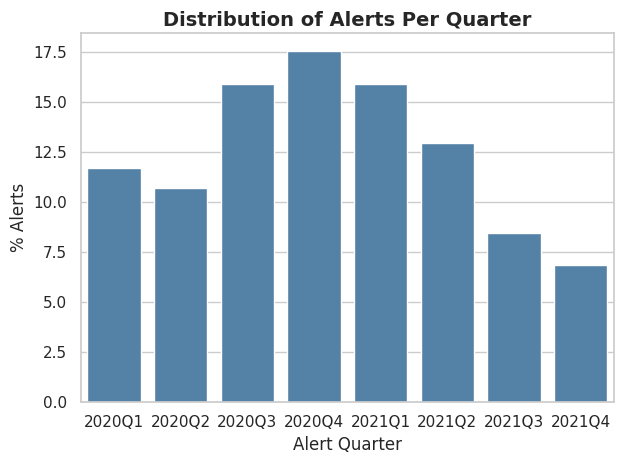

4380

In [10]:
df_gb = df_combined_data_pd.groupby(['Alert_Quarter'])['AlertID'].count().to_frame().reset_index()
df_gb["Fraction_Alert"]= 100* df_gb["AlertID"]/np.sum(df_gb["AlertID"])
sns.set(font_scale=1.15)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(df_gb, x="Alert_Quarter", y="Fraction_Alert",color='steelblue')
plt.xlabel('Alert Quarter', fontsize=12);
plt.ylabel('% Alerts', fontsize=12);
plt.title('Distribution of Alerts Per Quarter', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

del df_gb
gc.collect()

Key takeaways: There are more alert during 2020Q3 -2021Q1 compared to rest of the quarters

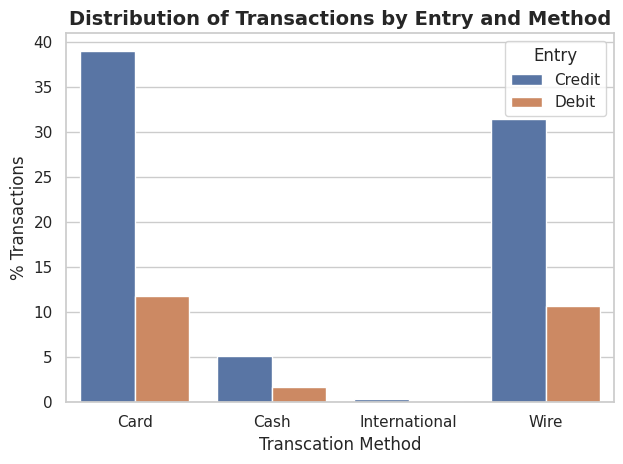

4438

In [11]:
df_gb=df_combined_data_pd.groupby(["Entry","Type"])["Size"].count().to_frame().reset_index()
df_gb["Fraction_Transaction"]= 100*df_gb["Size"]/np.sum(df_gb["Size"])
sns.barplot(df_gb, x="Type", y="Fraction_Transaction", hue="Entry")
plt.xlabel('Transcation Method', fontsize=12);
plt.ylabel('% Transactions', fontsize=12);
plt.title('Distribution of Transactions by Entry and Method', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
del df_gb
gc.collect()

Key Takeaways: Most of the transactions happened via Credit Type. In terms of transaction method, most common is Card and Wire 

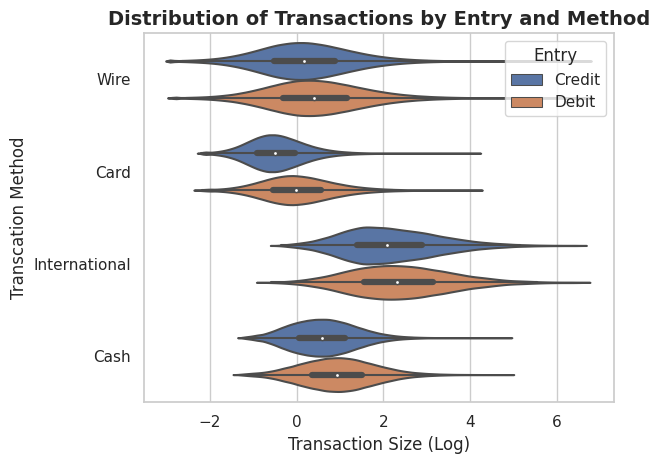

In [12]:
sns.violinplot(x="Size",data=df_combined_data_pd, y="Type", hue="Entry")
plt.xlabel('Transaction Size (Log)', fontsize=12);
plt.ylabel('Transcation Method', fontsize=12);
plt.title('Distribution of Transactions by Entry and Method', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

Key Takeaways: Distribution for each Transaction method is very similar between Credit and Debit Entry. However, the data is also skewed to the right.

Split the data in to training and test data.Timestamp before 2020 is used for training while the 2021 period is used for testing This is done as suggested in the paper

In [13]:
df_train= df_combined_data_pd[pd.to_datetime(df_combined_data_pd["Timestamp"]).dt.year == 2020]
df_test=df_combined_data_pd[pd.to_datetime(df_combined_data_pd["Timestamp"]).dt.year != 2020]

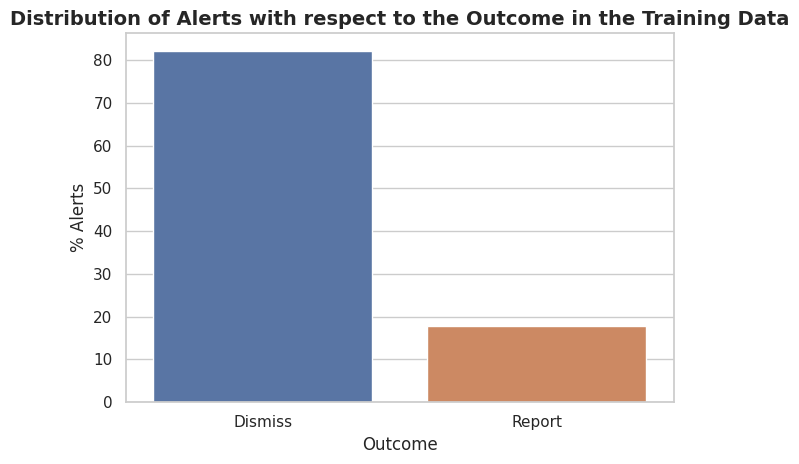

3173

In [14]:
df_gb = df_train.groupby(['Outcome'])['AlertID'].count().to_frame().reset_index()
df_gb["Fraction_Alert"]= 100* df_gb["AlertID"]/np.sum(df_gb["AlertID"])
sns.barplot(df_gb, x="Outcome", y="Fraction_Alert")
plt.xlabel('Outcome', fontsize=12);
plt.ylabel('% Alerts', fontsize=12);
plt.title('Distribution of Alerts with respect to the Outcome in the Training Data', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
del df_gb
gc.collect()

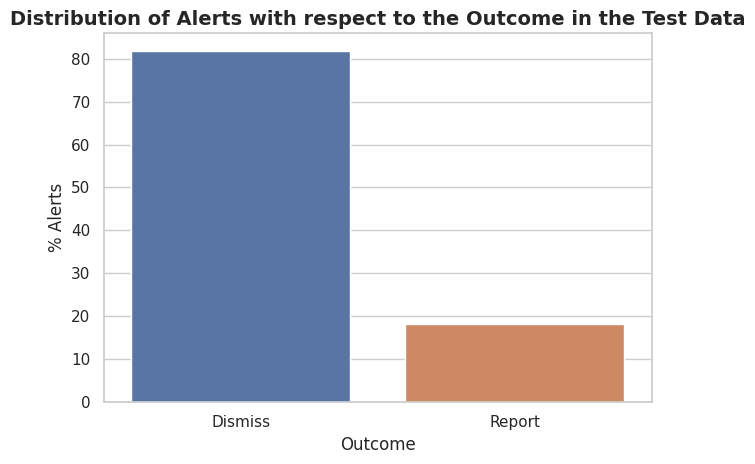

3419

In [15]:
df_gb = df_test.groupby(['Outcome'])['AlertID'].count().to_frame().reset_index()
df_gb["Fraction_Alert"]= 100*df_gb["AlertID"]/np.sum(df_gb["AlertID"])
sns.barplot(df_gb, x="Outcome", y="Fraction_Alert")
sns.barplot(df_gb, x="Outcome", y="Fraction_Alert")
plt.xlabel('Outcome', fontsize=12);
plt.ylabel('% Alerts', fontsize=12);
plt.title('Distribution of Alerts with respect to the Outcome in the Test Data', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
del df_gb
gc.collect()

Key Takeaways
* The data is imbalanced 
* Distribution is same in the test and training data

# Feature Engineering

In [16]:
#These functions are used to create several features as suggested in the paper. The missing value treatment is also done as suggested in the paper
def create_feature(df,ft_type, ft_miss):
    table =pd.pivot_table(df, index=["AlertID"],columns=["Entry","Type"], values=["Size"], aggfunc={'Size': [ft_type]}).reset_index()
    cols= table.columns.to_list()
    new_cols=[]
    for c in cols:
        new_cols.append('_'.join(c))
    
    table.columns= new_cols
    table= table.fillna(ft_miss)
    return table 

def calculate_new_features(df):
    table_max= create_feature(df, np.max, -3)
    table_min= create_feature(df, np.min, -3)
    table_mean=create_feature(df, np.mean, -3) 
    table_std=create_feature(df, np.std, -3) 
    table_median=create_feature(df, np.median, -3) 
    table_size=create_feature(df, np.size, 0) 
    table_sum=create_feature(df, np.sum, -3) 
    dfs=[table_max, table_min,table_mean,table_median, table_std,table_size, table_sum]

    final_table = reduce(lambda left,right:pd.merge(left,right, on=["AlertID___"], how="inner"), dfs)
    final_table= final_table.rename(columns={"AlertID___":"AlertID"})
    final_table_v1= pd.merge(final_table,df_alerts.to_pandas()[["AlertID","Outcome"]], on="AlertID", how="inner")
    return final_table_v1

In [17]:
df_train_final= calculate_new_features(df_train)
df_test_final= calculate_new_features(df_test)

# Data Pre-processing

In [18]:
label_enc= LabelEncoder()
df_train_final["Target"] = label_enc.fit_transform(df_train_final["Outcome"])
df_test_final["Target"] = label_enc.fit_transform(df_test_final["Outcome"])


X_train=df_train_final.copy()
X_train=X_train.drop(columns = ["Outcome","Target","AlertID"])
#X_train=X_train.drop(columns=cols_delete)
y_train= df_train_final["Target"]

X_test= df_test_final.copy()
X_test=X_test.drop(columns = ["Outcome","Target","AlertID"])
#X_test=X_test.drop(columns=cols_delete)
y_test= df_test_final["Target"]

#This is done to ensure that all the features have zero mean and unit variance
scaler=StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

# Hyperparameter Tunning - LGBM

In [19]:
#We tried 4 different seeds using Optuna to determine the optimal hyperparameters for LGBM
"""
def objective(trial):
    #Define the hyperparameters for LGBM
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1),
         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'boosting': trial.suggest_categorical('boosting', ['gbdt', 'dart']),
        "is_unbalance" :'True',
        "verbose": -1,
        "seed": 450000,
    }
    #Create and train the model
    model=LGBMClassifier(**params)
    model.fit(X_train_scaled,y_train)
    
    #Evaluate the model
    y_pred= model.predict(X_test_scaled)
    try:
         accuracy=roc_auc_score(y_pred,y_test)
    except ValueError:
         accuracy=0.5  
    
    return accuracy

study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)
print(f"Best Parameters: {study.best_params}")    """

'\ndef objective(trial):\n    #Define the hyperparameters for LGBM\n    params = {\n        \'objective\': \'binary\',\n        \'metric\': \'binary_logloss\',\n         \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 1e-8, 1),\n         \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 1e-8, 1),\n        "num_leaves": trial.suggest_int("num_leaves", 2, 256),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 1000, step=100),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.3),\n        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),\n        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),\n        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),\n        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),\n        \'boosting\': trial.suggest_categorical(\'boosting\', [\'gbdt\', \'dart\']),\n        "is_unbalance" :\'True\',\n        "verbose": -1,\n        "seed": 4500

In [20]:
#parameters={"verbose": 0,'reg_alpha': 0.20254850995533635, 'reg_lambda': 0.12867893545217435, 'num_leaves': 35, 'n_estimators': 400, 'learning_rate': 0.09432780815112071, 'feature_fraction': 0.716800455746426, 'bagging_fraction': 0.47152197625742265, 'bagging_freq': 1, 'min_child_samples': 17}

parameters= {'objective': 'binary', "seed": 450000, "is_unbalance" :'True',
        'metric': 'binary_logloss',"verbose": 0,'reg_alpha': 0.2703024100662205, 'reg_lambda': 0.16415960743496127, 'num_leaves': 141, 'n_estimators': 300, 'learning_rate': 0.010053895623470872, 'feature_fraction': 0.65109907985982, 'bagging_fraction': 0.781455387528108, 'bagging_freq': 1, 'min_child_samples': 74, 'boosting': 'dart'}
model= LGBMClassifier(**parameters)
lgbm1_pipeline=Pipeline(steps=[("model",model)])
lgbm1_pipeline.fit(X_train_scaled,y_train)
print(f" Accuracy on the test data: {roc_auc_score(lgbm1_pipeline.predict(X_test_scaled),y_test)}")

[LightGBM] [Warning] feature_fraction is set=0.65109907985982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65109907985982
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_fraction is set=0.781455387528108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.781455387528108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.65109907985982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65109907985982
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_fraction is set=0.781455387528108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.781455387528108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current 

In [21]:
parameters= {'objective': 'binary', "seed": 1, "is_unbalance" :'True',
        'metric': 'binary_logloss',"verbose": 0,'reg_alpha': 0.09799374825060599, 'reg_lambda': 0.5236106529537, 'num_leaves': 24, 'n_estimators': 200, 'learning_rate': 0.010178852331374392, 'feature_fraction': 0.45836663462677885, 'bagging_fraction': 0.4169059297529421, 'bagging_freq': 1, 'min_child_samples': 78, 'boosting': 'dart'}
model= LGBMClassifier(**parameters)
lgbm2_pipeline=Pipeline(steps=[("model",model)])
lgbm2_pipeline.fit(X_train_scaled,y_train)

print(f" Accuracy on the test data: {roc_auc_score(lgbm2_pipeline.predict(X_test_scaled),y_test)}")

[LightGBM] [Warning] feature_fraction is set=0.45836663462677885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45836663462677885
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_fraction is set=0.4169059297529421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4169059297529421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45836663462677885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45836663462677885
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_fraction is set=0.4169059297529421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4169059297529421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be i

In [22]:
parameters= {'objective': 'binary', "seed": 1000, "is_unbalance" :'True',
        'metric': 'binary_logloss',"verbose": 0,'reg_alpha': 0.0361848345303462, 'reg_lambda': 0.3496958590150242, 'num_leaves': 99, 'n_estimators': 100, 'learning_rate': 0.010236456760857725, 'feature_fraction': 0.5050713793511961, 'bagging_fraction': 0.6660990414129397, 'bagging_freq': 5, 'min_child_samples': 46, 'boosting': 'dart'}
model= LGBMClassifier(**parameters)
lgbm3_pipeline=Pipeline(steps=[("model",model)])
lgbm3_pipeline.fit(X_train_scaled,y_train)

print(f" Accuracy on the test data: {roc_auc_score(lgbm3_pipeline.predict(X_test_scaled),y_test)}")

[LightGBM] [Warning] feature_fraction is set=0.5050713793511961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050713793511961
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_fraction is set=0.6660990414129397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6660990414129397
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5050713793511961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050713793511961
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_fraction is set=0.6660990414129397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6660990414129397
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignor

In [23]:
parameters= {'objective': 'binary', "seed": 145, "is_unbalance" :'True',
        'metric': 'binary_logloss',"verbose": 0,'reg_alpha': 0.5697195714074832, 'reg_lambda': 0.6700825803697663, 'num_leaves': 129, 'n_estimators': 100, 'learning_rate': 0.0151093215134558, 'feature_fraction': 0.41783431722169667, 'bagging_fraction': 0.9214445404044942, 'bagging_freq': 6, 'min_child_samples': 35, 'boosting': 'gbdt'}
model= LGBMClassifier(**parameters)
lgbm4_pipeline=Pipeline(steps=[("model",model)])
lgbm4_pipeline.fit(X_train_scaled,y_train)

print(f" Accuracy on the test data: {roc_auc_score(lgbm4_pipeline.predict(X_test_scaled),y_test)}")

[LightGBM] [Warning] feature_fraction is set=0.41783431722169667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41783431722169667
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.9214445404044942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9214445404044942
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.41783431722169667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41783431722169667
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.9214445404044942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9214445404044942
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be i

# Hyperparameter Tunning - Histogram Based Gradient Boosting

In [24]:
##We tried 4 different seeds using Optuna to determine the optimal hyperparameters for Histogram Based Graident Boosting
"""
def objective(trial):
    #Define the hyperparameters for LGBM
    params = {
        'loss': 'log_loss',
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-8, 1),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 256),
        'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 4, 64),
        #"max_features": trial.suggest_float("max_features", 0.4, 1.0),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 100),
        "class_weight" :'balanced',
        "verbose": 0,
        "random_state": 56,
    }
    #Create and train the model
  
    model=HistGradientBoostingClassifier(**params)
    model.fit(X_train_scaled,y_train)
    
    #Evaluate the model
    y_pred= model.predict(X_test_scaled)
    try:
         accuracy=roc_auc_score(y_pred,y_test)
    except ValueError:
         accuracy=0.5  
    
    return accuracy

study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)
print(f"Best Parameters: {study.best_params}")    """

'\ndef objective(trial):\n    #Define the hyperparameters for LGBM\n    params = {\n        \'loss\': \'log_loss\',\n        \'l2_regularization\': trial.suggest_float(\'l2_regularization\', 1e-8, 1),\n        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 256),\n        \'max_iter\': trial.suggest_int(\'max_iter\', 100, 1000, step=100),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.3),\n        "max_depth": trial.suggest_int("max_depth", 4, 64),\n        #"max_features": trial.suggest_float("max_features", 0.4, 1.0),\n        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 100),\n        "class_weight" :\'balanced\',\n        "verbose": 0,\n        "random_state": 56,\n    }\n    #Create and train the model\n  \n    model=HistGradientBoostingClassifier(**params)\n    model.fit(X_train_scaled,y_train)\n    \n    #Evaluate the model\n    y_pred= model.predict(X_test_scaled)\n    try:\n         accuracy=roc_auc_score(y_pred,y_test)\n   

In [25]:
parameters= {"random_state": 56, "class_weight" :'balanced',
        'loss': 'log_loss',"verbose": 0,'l2_regularization': 0.8856011797229449, 'max_leaf_nodes': 65, 'max_iter': 500, 'learning_rate': 0.08514782732622847, 'max_depth': 25, 'min_samples_leaf': 95}
model= HistGradientBoostingClassifier(**parameters)
hgb1_pipeline=Pipeline(steps=[("model",model)])
hgb1_pipeline.fit(X_train_scaled,y_train)

print(f" Accuracy on the test data: {roc_auc_score(hgb1_pipeline.predict(X_test_scaled),y_test)}")

 Accuracy on the test data: 0.5653716850445971


In [26]:
parameters= {"random_state": 4, "class_weight" :'balanced',
        'loss': 'log_loss',"verbose": 0,'l2_regularization': 0.6747281154395162, 'max_leaf_nodes': 30, 'max_iter': 300, 'learning_rate': 0.030280318603348948, 'max_depth': 55, 'min_samples_leaf': 38}
model= HistGradientBoostingClassifier(**parameters)
hgb2_pipeline=Pipeline(steps=[("model",model)])
hgb2_pipeline.fit(X_train_scaled,y_train)

print(f" Accuracy on the test data: {roc_auc_score(hgb2_pipeline.predict(X_test_scaled),y_test)}")

 Accuracy on the test data: 0.5682483248947946


In [27]:
parameters= {"random_state": 45004, "class_weight" :'balanced',
        'loss': 'log_loss',"verbose": 0,'l2_regularization': 0.17321843919221783, 'max_leaf_nodes': 28, 'max_iter': 200, 'learning_rate': 0.03930712764704215, 'max_depth': 47, 'min_samples_leaf': 98}
model= HistGradientBoostingClassifier(**parameters)
hgb3_pipeline=Pipeline(steps=[("model",model)])
hgb3_pipeline.fit(X_train_scaled,y_train)

print(f" Accuracy on the test data: {roc_auc_score(hgb3_pipeline.predict(X_test_scaled),y_test)}")

 Accuracy on the test data: 0.566227400932117


In [28]:
parameters= {"random_state": 1004, "class_weight" :'balanced',
        'loss': 'log_loss',"verbose": 0,'l2_regularization': 0.1931731476071948, 'max_leaf_nodes': 37, 'max_iter': 600, 'learning_rate': 0.029239857170431063, 'max_depth': 25, 'min_samples_leaf': 89}
model= HistGradientBoostingClassifier(**parameters)
hgb4_pipeline=Pipeline(steps=[("model",model)])
hgb4_pipeline.fit(X_train_scaled,y_train)

print(f" Accuracy on the test data: {roc_auc_score(hgb4_pipeline.predict(X_test_scaled),y_test)}")

 Accuracy on the test data: 0.5643704798949318


# Hyperparameter Tunning - Logistic Regression

In [29]:
##We tried 4 different seeds using Optuna to determine the optimal hyperparameters for Logistic Regression
"""def objective(trial):
    #Define the hyperparameters for LGBM
    params = {
        "penalty": "l2",
        'C': trial.suggest_float('C', 1e-8, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear','newton-cg','newton-cholesky','sag','saga']),
        "class_weight" :'balanced',
        "verbose": 0,
        "random_state": 67,
    }
    #Create and train the model
  
    model=LogisticRegression(**params)
    model.fit(X_train_scaled,y_train)
    
    #Evaluate the model
    y_pred= model.predict(X_test_scaled)
    try:
         accuracy=roc_auc_score(y_pred,y_test)
    except ValueError:
         accuracy=0.5  
    
    return accuracy

study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)
print(f"Best Parameters: {study.best_params}")    """


'def objective(trial):\n    #Define the hyperparameters for LGBM\n    params = {\n        "penalty": "l2",\n        \'C\': trial.suggest_float(\'C\', 1e-8, 1),\n        \'max_iter\': trial.suggest_int(\'max_iter\', 100, 1000, step=100),\n        \'solver\': trial.suggest_categorical(\'solver\', [\'lbfgs\', \'liblinear\',\'newton-cg\',\'newton-cholesky\',\'sag\',\'saga\']),\n        "class_weight" :\'balanced\',\n        "verbose": 0,\n        "random_state": 67,\n    }\n    #Create and train the model\n  \n    model=LogisticRegression(**params)\n    model.fit(X_train_scaled,y_train)\n    \n    #Evaluate the model\n    y_pred= model.predict(X_test_scaled)\n    try:\n         accuracy=roc_auc_score(y_pred,y_test)\n    except ValueError:\n         accuracy=0.5  \n    \n    return accuracy\n\nstudy=optuna.create_study(direction=\'maximize\')\nstudy.optimize(objective, n_trials=150)\nprint(f"Best Parameters: {study.best_params}")    '

In [30]:
params = {
        "penalty": "l2",
        'C': 0.019755177230401058, 'max_iter': 200, 'solver': 'saga',
        "class_weight" :'balanced',
        "verbose": 0,
        "random_state": 45004,
    }

model= LogisticRegression(**params)
lr1_pipeline=Pipeline(steps=[("model",model)])
lr1_pipeline.fit(X_train_scaled,y_train)


print(f" Accuracy on the test data: {roc_auc_score(lr1_pipeline.predict(X_test_scaled),y_test)}")



 Accuracy on the test data: 0.5554295543546248


In [31]:
params = {
        "penalty": "l2",
        'C': 0.022152838548293537, 'max_iter': 1000, 'solver': 'saga',
        "class_weight" :'balanced',
        "verbose": 0,
        "random_state": 5,
    }

model= LogisticRegression(**params)
lr2_pipeline=Pipeline(steps=[("model",model)])
lr2_pipeline.fit(X_train_scaled,y_train)


print(f" Accuracy on the test data: {roc_auc_score(lr2_pipeline.predict(X_test_scaled),y_test)}")


 Accuracy on the test data: 0.5554225010170472


In [32]:
params = {
        "penalty": "l2",
        'C': 0.019627715205345654, 'max_iter': 600, 'solver': 'saga',
        "class_weight" :'balanced',
        "verbose": 0,
        "random_state": 67,
    }

model= LogisticRegression(**params)
lr3_pipeline=Pipeline(steps=[("model",model)])
lr3_pipeline.fit(X_train_scaled,y_train)

print(f" Accuracy on the test data: {roc_auc_score(lr3_pipeline.predict(X_test_scaled),y_test)}")


 Accuracy on the test data: 0.5555190617853929


In [33]:
params = {
        "penalty": "l2",
        'C': 0.023356838076404915, 'max_iter': 300, 'solver': 'lbfgs',
        "class_weight" :'balanced',
        "verbose": 0,
        "random_state": 5100,
    }

model= LogisticRegression(**params)
lr4_pipeline=Pipeline(steps=[("model",model)])
lr4_pipeline.fit(X_train_scaled,y_train)

print(f" Accuracy on the test data: {roc_auc_score(lr4_pipeline.predict(X_test_scaled),y_test)}")

 Accuracy on the test data: 0.5554431219005819


# Final Model 

In [34]:
#Overall performance of Logistic Regression Model
final_model = VotingClassifier(
estimators=[('LR4', lr4_pipeline), ('LR3', lr3_pipeline), ('LR2', lr2_pipeline),('LR1', lr1_pipeline)], voting='soft')
final_model.fit(X_train_scaled, y_train)
lr_result = roc_auc_score(final_model.predict(X_test_scaled),y_test)
print(f" Accuracy on the test data based on Average Linear Regression Approach: {roc_auc_score(final_model.predict(X_test_scaled),y_test)}")

 Accuracy on the test data based on Average Linear Regression Approach: 0.5551404014170349


In [35]:
#Overall performance of LGBM Model
final_model = VotingClassifier(
estimators=[ ('LGBM4',lgbm4_pipeline), ('LGBM3',lgbm3_pipeline), ('LGBM2',lgbm2_pipeline), ('LGBM1',lgbm1_pipeline)], voting='soft')

final_model.fit(X_train_scaled, y_train)
lgbm_result = roc_auc_score(final_model.predict(X_test_scaled),y_test)
print(f" Accuracy on the test data based on Average LGBM Approach: {roc_auc_score(final_model.predict(X_test_scaled),y_test)}")


[LightGBM] [Warning] feature_fraction is set=0.41783431722169667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41783431722169667
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.9214445404044942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9214445404044942
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.41783431722169667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41783431722169667
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.9214445404044942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9214445404044942
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be i

In [36]:
#Overall performance of Histogram Based Gradient Ensemble Model
final_model = VotingClassifier(
estimators=[('HGB4', hgb4_pipeline),('HGB3', hgb3_pipeline),('HGB2', hgb2_pipeline),('HGB1', hgb1_pipeline)], voting='soft')

final_model.fit(X_train_scaled, y_train)
hgb_result = roc_auc_score(final_model.predict(X_test_scaled),y_test)
print(f" Accuracy on the test data based on Average HGB Approach: {roc_auc_score(final_model.predict(X_test_scaled),y_test)}")


 Accuracy on the test data based on Average HGB Approach: 0.5681558100543791


In [37]:
#Result based on the all the models
final_model = VotingClassifier(
estimators=[('LR4', lr4_pipeline), ('LR3', lr3_pipeline), ('LR2', lr2_pipeline),('LR1', lr1_pipeline),('HGB4', hgb4_pipeline),('HGB3', hgb3_pipeline),('HGB2', hgb2_pipeline),('HGB1', hgb1_pipeline), ('LGBM4',lgbm4_pipeline), ('LGBM3',lgbm3_pipeline), ('LGBM2',lgbm2_pipeline), ('LGBM1',lgbm1_pipeline)], voting='soft')

final_model.fit(X_train_scaled, y_train)
combine_result= roc_auc_score(final_model.predict(X_test_scaled),y_test)
print(f" Accuracy on the test data based on ensemble Approach: {roc_auc_score(final_model.predict(X_test_scaled),y_test)}")


[LightGBM] [Warning] feature_fraction is set=0.41783431722169667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41783431722169667
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.9214445404044942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9214445404044942
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.41783431722169667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41783431722169667
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.9214445404044942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9214445404044942
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be i

In [38]:
Result_Analysis= pd.DataFrame(columns=["Modeling Approach","ROC AUC Score"])
Result_Analysis["Modeling Approach"] = ["Logistic Regression", "LightGBM", "Histogram Gradient Boosting", "Ensemble 3 Models"]
Result_Analysis["ROC AUC Score"] = [lr_result,lgbm_result,hgb_result,combine_result ]
Result_Analysis.style.set_caption("ROC AUC Score based on the Test Data").\
set_properties(**{'border': '1.3px solid blue','color': 'grey'})

,Modeling Approach,ROC AUC Score
0,Logistic Regression,0.555140
1,LightGBM,0.575931
2,Histogram Gradient Boosting,0.568156
3,Ensemble 3 Models,0.570585
